# 11_hyperbaton_detection.ipynb

**Hyperbaton Detection via Dependency Parses**

Detects adjective modifiers (`amod`) where the adjective is separated from its noun by >1 token and plots distributions including per-author bars.

In [3]:
from pathlib import Path

def setup_project_paths():
    current_dir = Path().cwd()
    base_path = current_dir.parent if current_dir.name == 'codigo' else current_dir
    tei_dir = base_path / 'corpus' / 'tei'
    csv_dir = base_path / 'resultados' / 'computational-analysis' / 'corpus_summary' / 'csv'
    ext_dir = base_path / 'resultados' / 'computational-analysis' / 'extensions'
    csv_dir.mkdir(parents=True, exist_ok=True)
    ext_dir.mkdir(parents=True, exist_ok=True)
    return tei_dir, csv_dir, ext_dir

TEI_DIR, CSV_DIR, EXT_DIR = setup_project_paths()

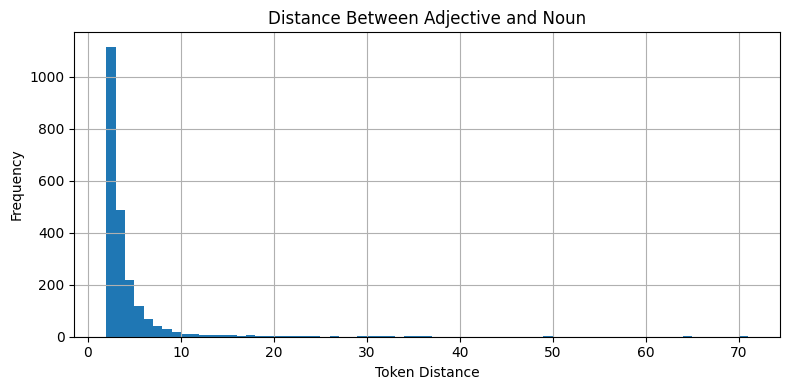

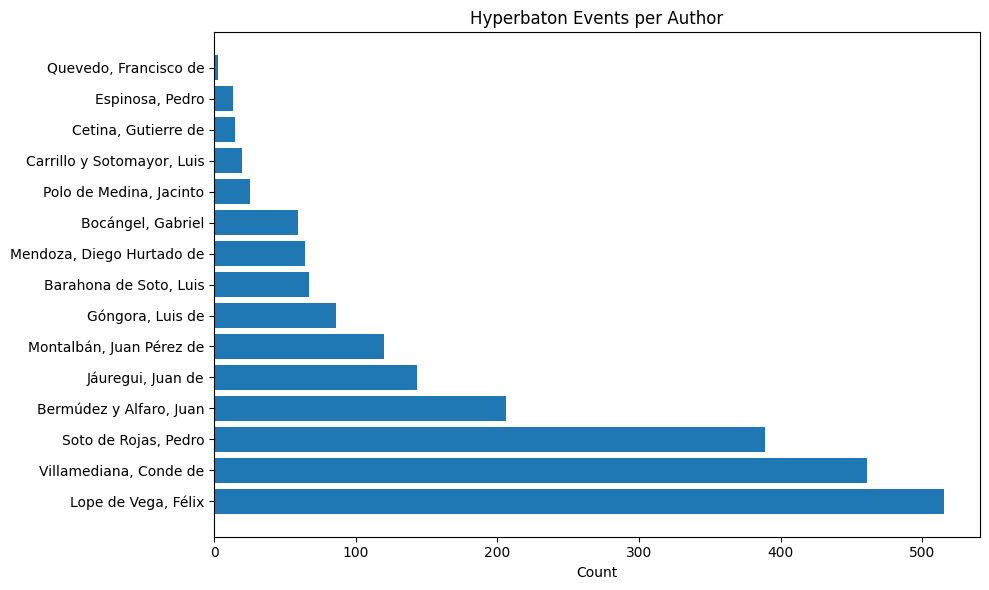

<Figure size 1000x600 with 0 Axes>

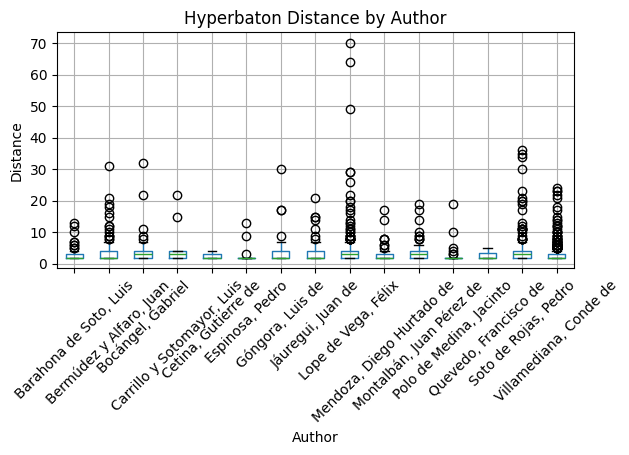

In [4]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt

# Load Spanish spaCy model
nlp = spacy.load('es_core_news_sm')

# Load raw texts
texts_df = pd.read_csv(CSV_DIR / 'raw_texts.csv')

# Load metadata for filename-author mapping
from lxml import etree
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
meta = []
for xml_file in TEI_DIR.glob('*.xml'):
    tree = etree.parse(str(xml_file))
    author_el = tree.find('.//tei:author', namespaces=ns)
    meta.append({'filename': xml_file.name, 'author': author_el.text if author_el is not None else 'Unknown'})
meta_df = pd.DataFrame(meta)

# Detect hyperbaton events
events = []
for _, row in texts_df.iterrows():
    fn = row['filename']
    text = row['text'] or ''
    doc = nlp(text)
    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            dist = abs(token.i - token.head.i)
            if dist > 1:
                sent = token.sent.text.strip()
                events.append({'filename': fn, 'sentence': sent, 'noun': token.head.text, 'adjective': token.text, 'distance': dist})

df_hyper = pd.DataFrame(events)
df_hyper.to_csv(EXT_DIR / 'hyperbaton_events.csv', index=False)

# Overall distance histogram
if not df_hyper.empty:
    plt.figure(figsize=(8,4))
    df_hyper['distance'].hist(bins=range(2, df_hyper['distance'].max()+2))
    plt.title('Distance Between Adjective and Noun')
    plt.xlabel('Token Distance')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(EXT_DIR / 'hyperbaton_distance_hist.png')
    plt.show()

# Merge with author metadata
df_auth = df_hyper.merge(meta_df, on='filename', how='left')

# Plot count per author
author_counts = df_auth['author'].value_counts()
plt.figure(figsize=(10,6))
plt.barh(author_counts.index, author_counts.values)
plt.title('Hyperbaton Events per Author')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig(EXT_DIR / 'hyperbaton_by_author.png')
plt.show()

# Plot distance distribution per author
if not df_auth.empty:
    plt.figure(figsize=(10,6))
    df_auth.boxplot(column='distance', by='author', rot=45)
    plt.title('Hyperbaton Distance by Author')
    plt.suptitle('')
    plt.xlabel('Author')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig(EXT_DIR / 'hyperbaton_distance_by_author.png')
    plt.show()
else:
    print("No hyperbaton events to plot per author.")